In [3]:
import tinyarray as ta
import numpy as np
import matplotlib.pyplot as plt
import importlib
import json
import kwant
from dask_quantumtinkerer import Cluster, cluster_options
import adaptive

import codes.trijunction as trijunction
import codes.optimization as optimization
import codes.parameters as parameters
from codes.system_functions import diagonalisation, adaptive_two_parameters
from codes.tools import hamiltonian
from codes.utils import eigsh, svd_transformation, dict_update, dep_acc_index, order_wavefunctions

VoronoiMesh version 0.1
DiscretePoisson version 0.3
Shape version: 0.1
SystEquations version: 0.3
Solver version 0.1


In [4]:
pairs = ['right-top', 'left-top', 'left-right']

In [5]:
from scipy.optimize import minimize, minimize_scalar

In [6]:
with open('/home/tinkerer/trijunction-design/codes/config.json', 'r') as f:
    config = json.load(f)

change_config = [
    {"device": {"thickness": {"dielectric": 1.0}}},
    {"gate": {"channel_width": 13.0, 'angle': np.pi/6, 'gap': 2}},
]

for local_config in change_config:
    config = dict_update(config, local_config)

In [7]:
system = trijunction.Trijunction(config)

In [8]:
system.make_system()

Finding closed voronoi cells
Done selecting closed voronoi cells
Calculating points distance
Done
Calculating ridges hypersurfaces
Done
Finding  hypervolume for closed voronoi cells
Done finding hypervolume for closed voronoi cells
Done calculating surface
Done calculating distance
Done calculating capacitance matrix


100%|██████████| 13/13 [00:30<00:00,  2.36s/it]


In [9]:
zero_potential = dict(
    zip(
        ta.array(system.site_coords[:, [0, 1]] - system.offset),
        np.zeros(len(system.site_coords)),
    )
)

In [10]:
kwant_args = list(system.optimiser_arguments().values())
#kwant_args[-1] = kwant_args[-1][order_wavefunctions(pair)]

In [11]:
params = parameters.junction_parameters()
params.update(potential=zero_potential)

In [12]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, 2e-3), depleted=-7e-3)

# Phase space 

## Optimisation routine 

In [24]:
%%time
optimal_phases = {}
for pair in pairs:
    params.update(voltages[pair])
    opt_args = tuple([pair, params, kwant_args])

    sol = minimize_scalar(
        optimization.loss,
        args=opt_args, 
        bounds=(0, 2), 
        method="bounded"
    )
    
    optimal_phases[pair] = parameters.phase_pairs(pair, sol.x)

CPU times: user 6min 25s, sys: 1min 20s, total: 7min 46s
Wall time: 7min 43s


In [25]:
optimal_phases

{'right-top': {'phi2': 1.313175736795625, 'phi1': 0},
 'left-top': {'phi2': 0.6884409234769429, 'phi1': 0},
 'left-right': {'phi1': 1.9107211575589333, 'phi2': 0}}

## Uniform grid sampling

In [13]:
options = cluster_options()
options.worker_cores = 2
options.worker_memory = 2
options.extra_path = "/home/jtorresluna/trijunction-design/"

In [14]:
# prepare arguments
phis = np.linspace(0, 2, 50) * np.pi
phases = {}

for pair in pairs:
    phases[pair] = [parameters.phase_pairs(pair, phi) for phi in phis]

In [15]:
# fixed voltage matrices
fixed_linear_matrices = [
    sum(
        [volts[key] * system.linear_terms[key] for key in system.linear_terms.keys()]
    ) for volts in voltages.values()
]

In [18]:
%%time
phase_relations = {}

cluster = Cluster(options)

cluster.scale(50)
client = cluster.get_client()
client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/966f3b0af7844f5db3732e4e28ffe9b0/status
CPU times: user 560 ms, sys: 125 ms, total: 686 ms
Wall time: 1min 9s


In [22]:
scattered_trijunction = client.scatter(system.trijunction, broadcast=True)
scattered_f_params = client.scatter(system.f_params, broadcast=True)
scattered_linear_terms = client.scatter(fixed_linear_matrices, broadcast=True)

In [23]:
%%time
for i, pair in enumerate(pairs):
    futures = client.map(
        diagonalisation,
        phases[pair],
        trijunction=scattered_trijunction,
        f_params=scattered_f_params,
        linear_terms=scattered_linear_terms[i],
        params=params
    )
    phase_relations[pair] = client.gather(futures)

CPU times: user 44.4 s, sys: 4.84 s, total: 49.2 s
Wall time: 2min 4s


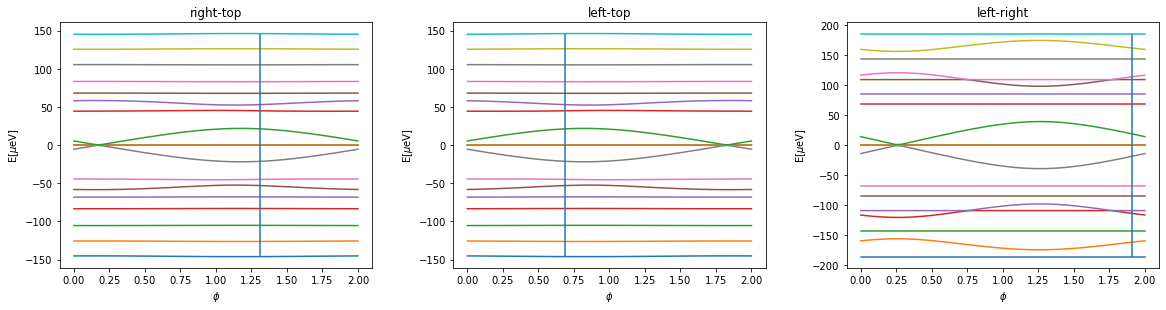

In [27]:
fig, axes = plt.subplots(ncols=3, figsize=(16, 4))
fig.tight_layout(w_pad=5)

for i, pair in enumerate(pairs):

    phase = 1e6*np.array(phase_relations[pair])

    axes[i].set_title(pair)
    axes[i].set_xlabel(r'$\phi$')
    axes[i].set_ylabel(r'E[$\mu$eV]')

    axes[i].plot(phis/np.pi, phase)
    opt_phase = list(list(optimal_phases.values())[i].values())[0]
    axes[i].vlines(opt_phase, ymin=-np.max(phase), ymax=np.max(phase))

In [ ]:
optimal_

# Voltage space exploration

## Optimisation 

In [161]:
dep_index, acc_index = dep_acc_index(
            system.poisson_system,
            system.site_indices,
            system.geometry,
            pair,
        )

In [158]:
ham = hamiltonian(
    kwant_system=system.trijunction,
    linear_terms=system.linear_terms,
    params_fn=system.f_params,
    **params,
)

In [159]:
ham

<115112x115112 sparse matrix of type '<class 'numpy.complex128'>'
	with 1181856 stored elements in Compressed Sparse Row format>

In [163]:
kwant_grid = [site.pos for site in system.trijunction.sites]

In [18]:
# loss to optimize voltages
params.update(optimal_phase)
opt_args = tuple([pair, params, kwant_args])
optimization.loss(x, *opt_args)

3.6413198571384764

In [ ]:
sol1 = minimize(
            optimization.loss,
            x,
            args=opt_args,
            method="trust-constr",
            options={
                "verbose": 2,
                "initial_tr_radius": 1e-3,
                # "gtol": 1e-1,
            },
        )

| niter |f evals|CG iter|  obj func   |tr radius |   opt    |  c viol  |
|-------|-------|-------|-------------|----------|----------|----------|
|   1   |   5   |   0   | +3.6413e+00 | 1.00e-03 | 2.41e+03 | 0.00e+00 |
|   2   |  10   |   1   | -2.1138e+00 | 7.00e-03 | 6.44e+03 | 0.00e+00 |
|   3   |  15   |   2   | -5.1649e+00 | 7.00e-03 | 4.05e+01 | 0.00e+00 |
|   4   |  20   |   3   | -5.1652e+00 | 7.00e-03 | 4.03e+01 | 0.00e+00 |
|   5   |  25   |   5   | -5.1652e+00 | 1.61e-03 | 4.03e+01 | 0.00e+00 |
|   6   |  30   |   6   | -5.1652e+00 | 8.07e-04 | 4.03e+01 | 0.00e+00 |
|   7   |  35   |   7   | -5.1652e+00 | 2.99e-04 | 4.03e+01 | 0.00e+00 |
|   8   |  40   |   8   | -5.1889e+00 | 2.09e-03 | 1.59e+02 | 0.00e+00 |
|   9   |  45   |  11   | -5.1889e+00 | 2.53e-04 | 1.59e+02 | 0.00e+00 |
|  10   |  50   |  13   | -5.2199e+00 | 1.77e-03 | 8.09e+02 | 0.00e+00 |
|  11   |  55   |  15   | -5.2199e+00 | 8.87e-04 | 8.09e+02 | 0.00e+00 |
|  12   |  60   |  18   | -5.2199e+00 | 2.96e-04 | 

In [93]:
params.update(parameters.voltage_dict(sol1.x))
opt_args = tuple([pair, params, kwant_args])

In [59]:
optimiser_args = system.optimiser_arguments()

numerical_hamiltonian = hamiltonian(system.trijunction, 
                                    optimiser_args['linear_terms'], 
                                    optimiser_args['kwant_params_fn'], 
                                    **params)

In [61]:
energies, wave_functions = eigsh(
                numerical_hamiltonian.tocsc(),
                6,
                sigma=0,
                return_eigenvectors=True,
)

In [75]:
transformed_hamiltonian = svd_transformation(
    energies, wave_functions, reference_wave_functions
)

desired = np.abs(transformed_hamiltonian[0, 1])
undesired = np.linalg.norm(transformed_hamiltonian[2:])

In [77]:
desired

2.430561344761288e-05

## Adaptive exploration 

In [28]:
plunger_min = -5e-3
plunger_max = 5e-3

bounds = [
    (plunger_min, plunger_max),
    (plunger_min, plunger_max),
]

In [43]:
cluster = await Cluster(options, asynchronous=True)

await cluster.scale(50)
client = await cluster.get_client()
await client.wait_for_workers(1)
print("http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/"+cluster.dashboard_link[17:])

http://io.quantumtinkerer.tudelft.nl/user/jdtorres/proxy/8000/clusters/6eff509412214a50ae0fec1ddf813f3b/status


In [44]:
pair = 'right-top'

In [45]:
voltages = parameters.pair_voltages(initial=(-1.0e-3, -1.0e-3, -1.0e-3, 0), depleted=-7e-3)

In [46]:
params = parameters.junction_parameters()
params.update(potential=zero_potential)
base_ham = system.trijunction.hamiltonian_submatrix(sparse=True, params=system.f_params(**params))

In [47]:
scattered_base_ham = await client.scatter(base_ham, broadcast=True)
scattered_linear_matrices = await client.scatter(system.linear_terms, broadcast=True)

In [48]:
async def f_async(xy):
    future = client.submit(
        adaptive_two_parameters,
        xy,
        trijunction=scattered_base_ham,
        linear_terms=scattered_linear_matrices,
        keys=('top', 'right'),
        params=voltages[pair]
    )

    return await future

In [49]:
learner = adaptive.Learner2D(f_async, bounds=bounds)

In [50]:
runner = adaptive.AsyncRunner(
    learner,
    goal=lambda l: l.loss() < 0.001,
    ntasks=199
)

In [55]:
_, _, z = learner.interpolated_on_grid()

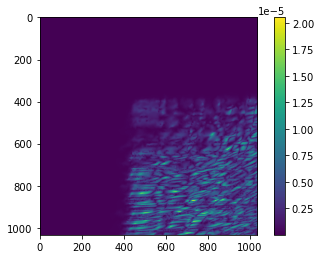

In [56]:
plot = plt.imshow(z)
plt.colorbar(plot)

In [57]:
runner.cancel()